In [13]:
%load_ext autoreload
%autoreload 2
import pickle
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd

import data_pre_processing
import dataset_pre_processing
import pre_training
import raw_data_processing
from raw_data_processing import process_PAMAP2_all_data, process_hhar_all_files, process_motion_sense_all_files, open_pickle
import numpy as np
import scipy.stats
import data_pre_processing
import self_har_models
import tensorflow as tf
import seaborn as sns
tf.get_logger().setLevel('INFO')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data pre-processing

In [3]:
# get data from pickle 

with open('pickled_datasets/pamap.pickle', 'rb') as file:
    pamap_df = pickle.load(file)
with open('pickled_datasets/hhar.pickle', 'rb') as file:
    hhar_df = pickle.load(file)
with open('pickled_datasets/motionsense.pickle', 'rb') as file:
    motion_sense_df = pickle.load(file)
    
def concat_datasets(datasets, sensor_type):
    concated_datasets = {}
    ##TODO need to check key to see whether mag exists
    for df in datasets:
        concated_datasets.update(df[sensor_type])
    return concated_datasets

cdf = concat_datasets([pamap_df, hhar_df, motion_sense_df], "acc")
def get_labels(data):
    all_labels = []
    for user in data:
        all_labels = np.concatenate((np.unique(data[user][0][1]), all_labels))
    labels = np.unique(all_labels)
    return labels

labels = get_labels(cdf)
label_map = {label: index for index, label in enumerate(labels)}
print(label_map)
user_datasets_processed = data_pre_processing.pre_process_dataset_composite(
    cdf, label_map, 6, 
    ['101', '102', '103', '104', '105', '106', '107', 'a', 'b', 'c', 'd', 'e', 'f', 'g', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'], 
    ["108", "109", "h", "i", "21", "22", "23", "24"], 400, 200
)

{'IMU ankle': 0, 'IMU chest': 1, 'IMU hand': 2, 'Phone': 3, 'Watch': 4, 'iphone': 5}
getting mean
[-0.18597652  1.40292431  4.05411898]
[6.31367612 5.0870368  5.47022979]
normalising train set
normalisnig test


# Create a CNN Model

In [4]:
test_model = self_har_models.create_1d_conv_core_model((400,3), "HAR")
cnn_model = self_har_models.attach_full_har_classification_head(test_model, 6, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))
cnn_history = cnn_model.fit(user_datasets_processed[0][0], user_datasets_processed[0][1]
                    , epochs=10, validation_data=(user_datasets_processed[1][0], user_datasets_processed[1][1]))

Epoch 1/10


2023-10-26 12:50:14.074298: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-10-26 12:50:14.280245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:655] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2499/2499 [==============================] - 14s 5ms/step - loss: 0.2001 - categorical_accuracy: 0.9421 - auc: 0.9946 - precision: 0.9481 - recall: 0.9372 - val_loss: 0.2058 - val_categorical_accuracy: 0.9531 - val_auc: 0.9941 - val_precision: 0.9600 - val_recall: 0.9430
Epoch 2/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.1406 - categorical_accuracy: 0.9596 - auc: 0.9971 - precision: 0.9620 - recall: 0.9572 - val_loss: 0.1431 - val_categorical_accuracy: 0.9627 - val_auc: 0.9976 - val_precision: 0.9702 - val_recall: 0.9583
Epoch 3/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.1229 - categorical_accuracy: 0.9650 - auc: 0.9976 - precision: 0.9672 - recall: 0.9631 - val_loss: 0.2143 - val_categorical_accuracy: 0.9384 - val_auc: 0.9945 - val_precision: 0.9534 - val_recall: 0.9194
Epoch 4/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.1121 - categorical_accuracy: 0.9691 - auc: 0.9980 - precision: 0.9704 - recall: 0.9

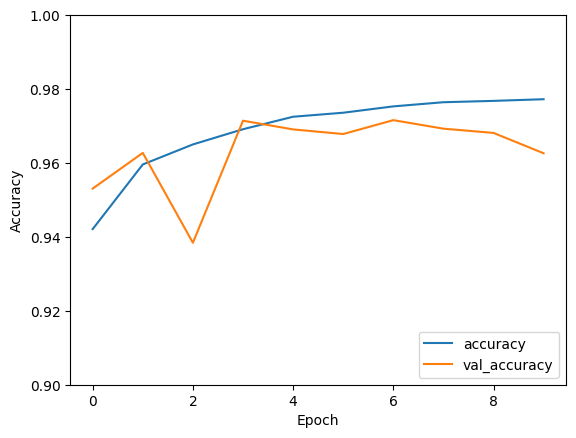

660/660 [==============================] - 1s 1ms/step


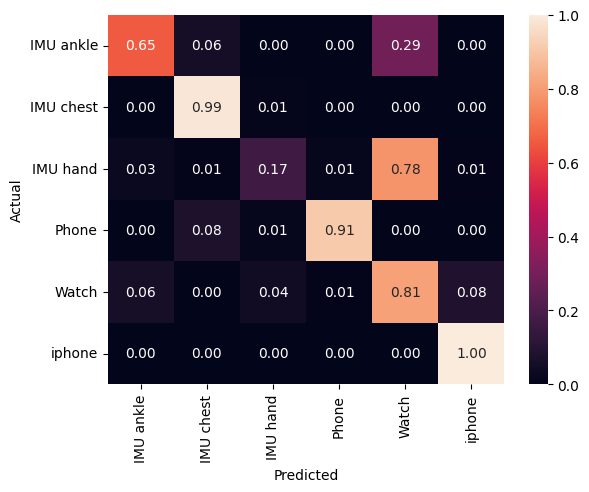

In [7]:
import matplotlib.pyplot as plt
plt.plot(cnn_history.history['categorical_accuracy'], label='accuracy')
plt.plot(cnn_history.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.9, 1])
plt.legend(loc='lower right')
plt.show()

cnn_test_result = cnn_model.evaluate(user_datasets_processed[2][0],  user_datasets_processed[2][1], return_dict=True)

predicted_labels = np.argmax(cnn_model.predict(user_datasets_processed[2][0]), axis=1)
true_labels = np.argmax(user_datasets_processed[2][1], axis=1)
confusion_mat = tf.math.confusion_matrix(true_labels, predicted_labels)
cm = confusion_mat.numpy()
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

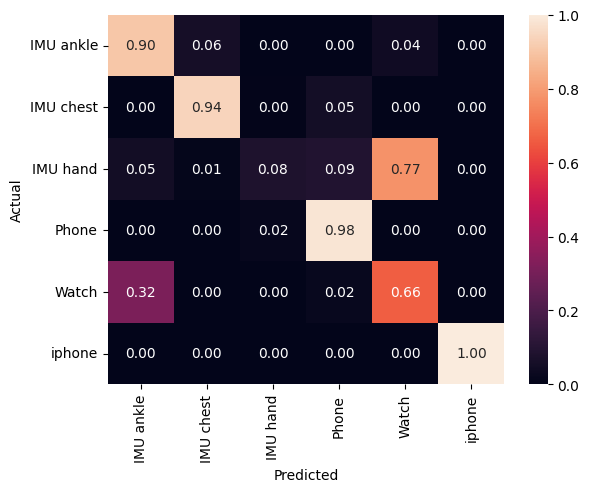

# Create LSTM-Model

In [14]:
inputs = tf.keras.Input(shape=(400,3), name='input')
x = inputs
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(96))(x)
x = tf.keras.layers.Dense(96, activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='sigmoid')(x)
LSTM_model = tf.keras.Model(inputs, x, name="LSTM-CNN")
print(LSTM_model.summary())
full_LSTM_model = self_har_models.attach_full_har_classification_head(LSTM_model, 6, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))
LSTM_history = full_LSTM_model.fit(user_datasets_processed[0][0], user_datasets_processed[0][1]
                    , epochs=10, validation_data=(user_datasets_processed[1][0], user_datasets_processed[1][1]))

2023-10-26 13:24:01.625718: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-26 13:24:01.627778: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-26 13:24:01.629173: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "LSTM-CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 400, 3)]          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 192)              76800     
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 96)                18528     
                                                                 
 dense_11 (Dense)            (None, 100)               9700      
                                                                 
Total params: 105,028
Trainable params: 105,028
Non-trainable params: 0
_________________________________________________________________
None


2023-10-26 13:24:02.014676: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-26 13:24:02.016735: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-26 13:24:02.018145: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-10-26 13:24:03.062510: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-26 13:24:03.065085: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-26 13:24:03.066652: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2497/2499 [============================>.] - ETA: 0s - loss: 0.3265 - categorical_accuracy: 0.9043 - auc: 0.9856 - precision: 0.9168 - recall: 0.8935

2023-10-26 13:25:02.077429: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-26 13:25:02.079430: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-26 13:25:02.080998: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2499/2499 [==============================] - 65s 25ms/step - loss: 0.3265 - categorical_accuracy: 0.9043 - auc: 0.9856 - precision: 0.9168 - recall: 0.8935 - val_loss: 0.3106 - val_categorical_accuracy: 0.9093 - val_auc: 0.9873 - val_precision: 0.9226 - val_recall: 0.8891
Epoch 2/10
2499/2499 [==============================] - 58s 23ms/step - loss: 0.2630 - categorical_accuracy: 0.9195 - auc: 0.9904 - precision: 0.9268 - recall: 0.9125 - val_loss: 0.2638 - val_categorical_accuracy: 0.9185 - val_auc: 0.9914 - val_precision: 0.9285 - val_recall: 0.9086
Epoch 3/10
2499/2499 [==============================] - 61s 24ms/step - loss: 0.2280 - categorical_accuracy: 0.9291 - auc: 0.9926 - precision: 0.9348 - recall: 0.9239 - val_loss: 0.2048 - val_categorical_accuracy: 0.9368 - val_auc: 0.9939 - val_precision: 0.9393 - val_recall: 0.9340
Epoch 4/10
2499/2499 [==============================] - 60s 24ms/step - loss: 0.2006 - categorical_accuracy: 0.9367 - auc: 0.9939 - precision: 0.9406 - recall:

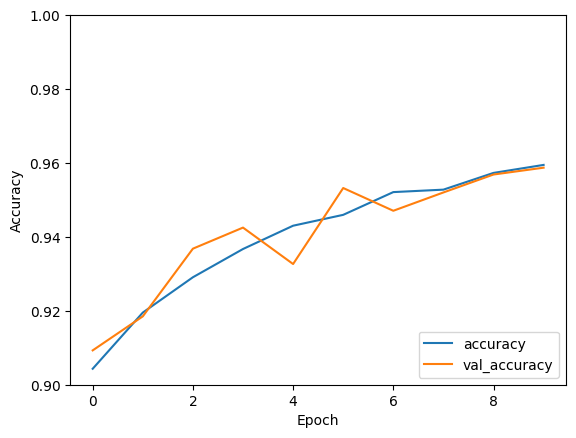

660/660 [==============================] - 6s 9ms/step - loss: 0.8416 - categorical_accuracy: 0.8188 - auc: 0.9440 - precision: 0.8230 - recall: 0.8166


2023-10-26 13:34:15.996576: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-26 13:34:15.998581: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-26 13:34:15.999856: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

660/660 [==============================] - 6s 9ms/step


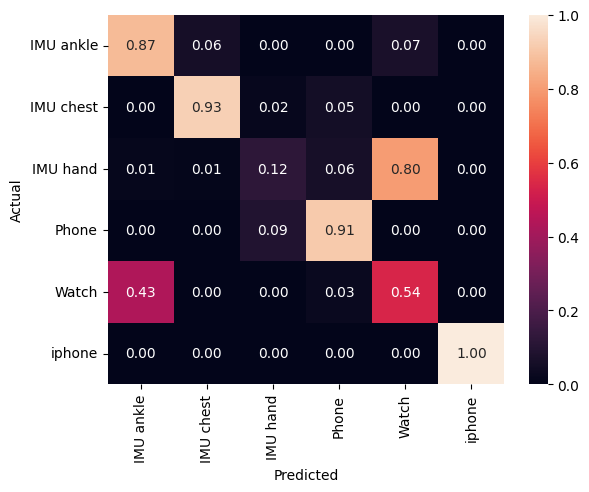

In [15]:
import matplotlib.pyplot as plt
plt.plot(LSTM_history.history['categorical_accuracy'], label='accuracy')
plt.plot(LSTM_history.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.9, 1])
plt.legend(loc='lower right')
plt.show()

lstm_test_result = full_LSTM_model.evaluate(user_datasets_processed[2][0],  user_datasets_processed[2][1], return_dict=True)
predicted_labels = np.argmax(full_LSTM_model.predict(user_datasets_processed[2][0]), axis=1)
true_labels = np.argmax(user_datasets_processed[2][1], axis=1)
confusion_mat = tf.math.confusion_matrix(true_labels, predicted_labels)
cm = confusion_mat.numpy()
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [28]:
inputs = tf.keras.Input(shape=(400,3), name='input')
x = inputs
x = tf.keras.layers.Dense(300, activation='relu')(x)
x = tf.keras.layers.Conv1D(
        64, 3,
        activation='relu',
        strides = 1,
        kernel_regularizer=tf.keras.regularizers.l2(l=1e-4)
    )(x)
x = tf.keras.layers.Conv1D(
        128, 3,
        activation='relu',
        strides = 1,
        kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.MaxPool1D(pool_size=4, padding='valid', data_format='channels_last', strides=2)(x)

x = tf.keras.layers.Conv1D(
    128, 5,
    activation='relu',
    strides = 2,
    kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.Conv1D(
    256, 5,
    activation='relu',
    strides = 2,
    kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.MaxPool1D(pool_size=4, padding='valid', data_format='channels_last', strides=2)(x)

x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(96))(x)
x = tf.keras.layers.Dropout(0.4)(x)
# x = tf.keras.layers.Dense(96, activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='softmax')(x)

CNNLSTN_model = tf.keras.Model(inputs, x, name="CNN-LSTM")
print(CNNLSTN_model.summary())

2023-10-26 13:46:42.723321: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-26 13:46:42.725435: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-26 13:46:42.726817: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "CNN-LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 400, 3)]          0         
                                                                 
 dense_38 (Dense)            (None, 400, 300)          1200      
                                                                 
 conv1d_40 (Conv1D)          (None, 398, 64)           57664     
                                                                 
 conv1d_41 (Conv1D)          (None, 396, 128)          24704     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 197, 128)         0         
 1D)                                                             
                                                                 
 conv1d_42 (Conv1D)          (None, 97, 128)           82048     
                                                          

In [29]:
full_CNNLSTM_model = self_har_models.attach_full_har_classification_head(CNNLSTN_model, 6, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))
CNNLSTM_history = full_CNNLSTM_model.fit(user_datasets_processed[0][0], user_datasets_processed[0][1]
                    , epochs=10, validation_data=(user_datasets_processed[1][0], user_datasets_processed[1][1]))

2023-10-26 13:46:45.651240: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-26 13:46:45.653304: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-26 13:46:45.654777: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-10-26 13:46:46.736890: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-26 13:46:46.738925: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-26 13:46:46.740509: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2499/2499 [==============================] - ETA: 0s - loss: 0.4361 - categorical_accuracy: 0.8598 - auc: 0.9794 - precision: 0.9213 - recall: 0.8249

2023-10-26 13:47:11.466796: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-26 13:47:11.468713: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-26 13:47:11.470137: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2499/2499 [==============================] - 28s 10ms/step - loss: 0.4361 - categorical_accuracy: 0.8598 - auc: 0.9794 - precision: 0.9213 - recall: 0.8249 - val_loss: 0.2726 - val_categorical_accuracy: 0.9391 - val_auc: 0.9868 - val_precision: 0.9402 - val_recall: 0.9385
Epoch 2/10
2499/2499 [==============================] - 23s 9ms/step - loss: 0.2398 - categorical_accuracy: 0.9411 - auc: 0.9914 - precision: 0.9443 - recall: 0.9389 - val_loss: 0.1983 - val_categorical_accuracy: 0.9488 - val_auc: 0.9930 - val_precision: 0.9512 - val_recall: 0.9472
Epoch 3/10
2499/2499 [==============================] - 23s 9ms/step - loss: 0.2218 - categorical_accuracy: 0.9435 - auc: 0.9929 - precision: 0.9468 - recall: 0.9411 - val_loss: 0.1952 - val_categorical_accuracy: 0.9504 - val_auc: 0.9936 - val_precision: 0.9514 - val_recall: 0.9494
Epoch 4/10
2499/2499 [==============================] - 23s 9ms/step - loss: 0.1924 - categorical_accuracy: 0.9490 - auc: 0.9947 - precision: 0.9520 - recall: 0.

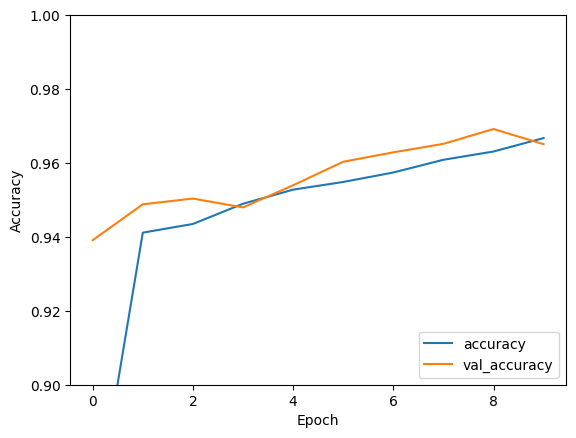

660/660 [==============================] - 3s 4ms/step - loss: 0.8300 - categorical_accuracy: 0.8517 - auc: 0.9418 - precision: 0.8527 - recall: 0.8504


2023-10-26 13:51:28.774788: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-26 13:51:28.776979: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-26 13:51:28.778488: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

660/660 [==============================] - 2s 3ms/step


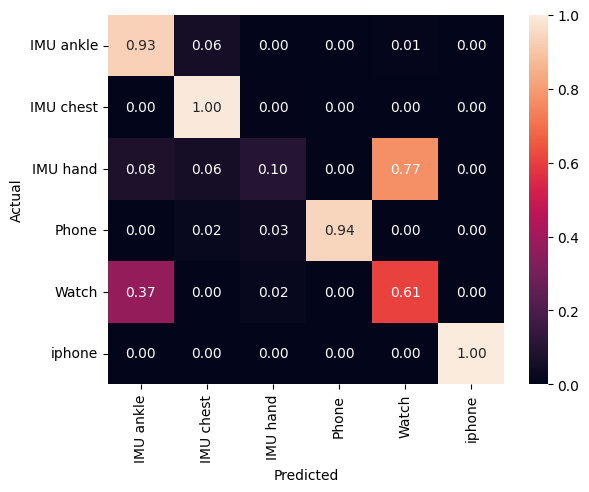

In [30]:
import matplotlib.pyplot as plt
plt.plot(CNNLSTM_history.history['categorical_accuracy'], label='accuracy')
plt.plot(CNNLSTM_history.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.9, 1])
plt.legend(loc='lower right')
plt.show()

lstm_test_result = full_CNNLSTM_model.evaluate(user_datasets_processed[2][0],  user_datasets_processed[2][1], return_dict=True)
predicted_labels = np.argmax(full_CNNLSTM_model.predict(user_datasets_processed[2][0]), axis=1)
true_labels = np.argmax(user_datasets_processed[2][1], axis=1)
confusion_mat = tf.math.confusion_matrix(true_labels, predicted_labels)
cm = confusion_mat.numpy()
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [38]:
inputs = tf.keras.Input(shape=(400,3), name='input')
x = inputs
x = tf.keras.layers.Dense(300, activation='relu')(x)
x = tf.keras.layers.Conv1D(
        64, 3,
        activation='relu',
        strides = 1,
        kernel_regularizer=tf.keras.regularizers.l2(l=1e-4)
    )(x)
x = tf.keras.layers.Conv1D(
        128, 3,
        activation='relu',
        strides = 1,
        kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.MaxPool1D(pool_size=4, padding='valid', data_format='channels_last', strides=2)(x)

x = tf.keras.layers.Conv1D(
    128, 5,
    activation='relu',
    strides = 2,
    kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.Conv1D(
    256, 5,
    activation='relu',
    strides = 2,
    kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.MaxPool1D(pool_size=4, padding='valid', data_format='channels_last', strides=2)(x)

x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.LSTM(300, return_sequences=True)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300))(x)
x = tf.keras.layers.Dropout(0.4)(x)
# x = tf.keras.layers.Dense(96, activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='softmax')(x)

CNNLSTN2_model = tf.keras.Model(inputs, x, name="CNN-LSTM")
print(CNNLSTN2_model.summary())

2023-10-26 14:18:38.922820: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-26 14:18:38.924696: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-26 14:18:38.926209: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "CNN-LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 400, 3)]          0         
                                                                 
 dense_54 (Dense)            (None, 400, 300)          1200      
                                                                 
 conv1d_68 (Conv1D)          (None, 398, 64)           57664     
                                                                 
 conv1d_69 (Conv1D)          (None, 396, 128)          24704     
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 197, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_70 (Conv1D)          (None, 97, 128)           82048     
                                                          

# Try another CNN-LSTM Model

In [39]:
full_CNNLSTM2_model = self_har_models.attach_full_har_classification_head(CNNLSTN2_model, 6, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))
CNNLSTM2_history = full_CNNLSTM2_model.fit(user_datasets_processed[0][0], user_datasets_processed[0][1]
                    , epochs=10, validation_data=(user_datasets_processed[1][0], user_datasets_processed[1][1]))

2023-10-26 14:18:53.833997: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-26 14:18:53.835879: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-26 14:18:53.837248: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-10-26 14:18:55.096352: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-26 14:18:55.098555: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-26 14:18:55.099950: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2496/2499 [============================>.] - ETA: 0s - loss: 0.4929 - categorical_accuracy: 0.8343 - auc: 0.9749 - precision: 0.8845 - recall: 0.7907

2023-10-26 14:19:26.857762: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-26 14:19:26.859798: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-26 14:19:26.861147: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2499/2499 [==============================] - 36s 13ms/step - loss: 0.4926 - categorical_accuracy: 0.8344 - auc: 0.9750 - precision: 0.8846 - recall: 0.7909 - val_loss: 0.2584 - val_categorical_accuracy: 0.9405 - val_auc: 0.9894 - val_precision: 0.9417 - val_recall: 0.9393
Epoch 2/10
2499/2499 [==============================] - 31s 12ms/step - loss: 0.2593 - categorical_accuracy: 0.9366 - auc: 0.9904 - precision: 0.9401 - recall: 0.9337 - val_loss: 0.2245 - val_categorical_accuracy: 0.9490 - val_auc: 0.9923 - val_precision: 0.9501 - val_recall: 0.9478
Epoch 3/10
2499/2499 [==============================] - 31s 12ms/step - loss: 0.2369 - categorical_accuracy: 0.9405 - auc: 0.9920 - precision: 0.9435 - recall: 0.9377 - val_loss: 0.2056 - val_categorical_accuracy: 0.9503 - val_auc: 0.9940 - val_precision: 0.9557 - val_recall: 0.9466
Epoch 4/10
2499/2499 [==============================] - 31s 12ms/step - loss: 0.2251 - categorical_accuracy: 0.9419 - auc: 0.9929 - precision: 0.9454 - recall:

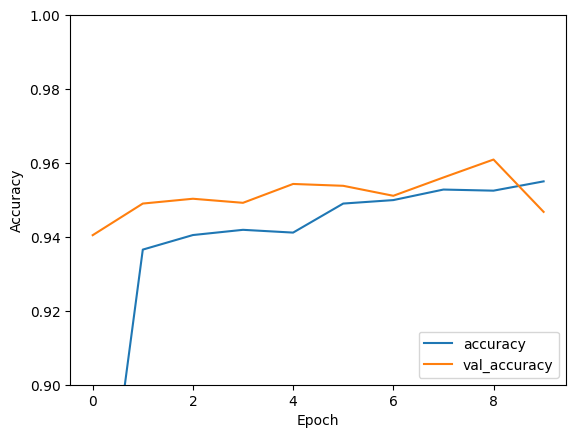

660/660 [==============================] - 4s 5ms/step - loss: 0.7380 - categorical_accuracy: 0.8171 - auc: 0.9352 - precision: 0.8217 - recall: 0.8162


2023-10-26 14:31:24.445931: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-26 14:31:24.448012: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-26 14:31:24.449363: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

660/660 [==============================] - 3s 4ms/step


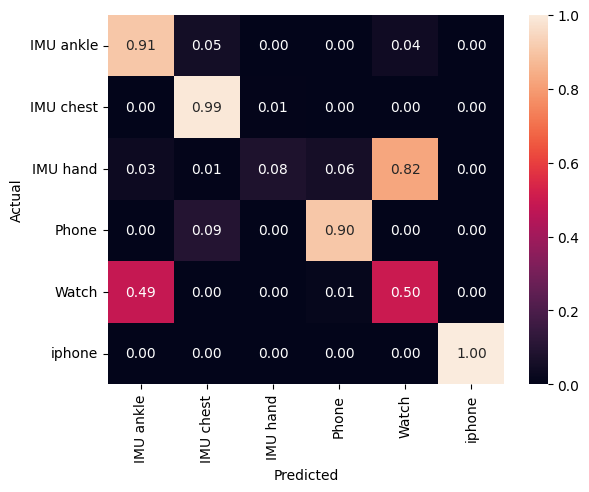

In [40]:
plt.plot(CNNLSTM2_history.history['categorical_accuracy'], label='accuracy')
plt.plot(CNNLSTM2_history.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.9, 1])
plt.legend(loc='lower right')
plt.show()

lstm_test_result = full_CNNLSTM2_model.evaluate(user_datasets_processed[2][0],  user_datasets_processed[2][1], return_dict=True)
predicted_labels = np.argmax(full_CNNLSTM2_model.predict(user_datasets_processed[2][0]), axis=1)
true_labels = np.argmax(user_datasets_processed[2][1], axis=1)
confusion_mat = tf.math.confusion_matrix(true_labels, predicted_labels)
cm = confusion_mat.numpy()
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)